In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, homogeneity_score, completeness_score,silhouette_score, calinski_harabasz_score, davies_bouldin_score



In [59]:
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=";", na_values="?", header=0
)

In [68]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime,Other_active_energy,Hour,Period,Day
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,52.266667,17,Soir,2006-12-16
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,72.333333,17,Soir,2006-12-16
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,70.566667,17,Soir,2006-12-16
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,71.800000,17,Soir,2006-12-16
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,43.100000,17,Soir,2006-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,15.766667,20,Soir,2010-11-26
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,15.733333,20,Soir,2010-11-26
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,15.633333,21,Soir,2010-11-26
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,15.566667,21,Soir,2010-11-26


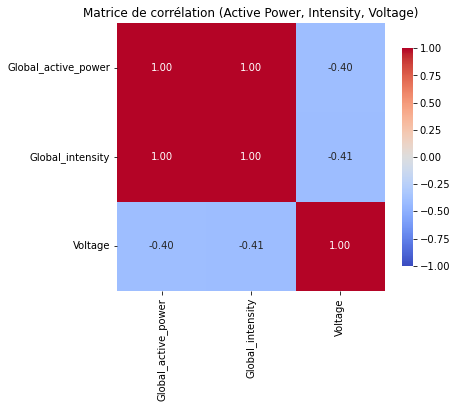

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["Global_active_power", "Global_intensity", "Voltage"]
corr = df[cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
plt.title("Matrice de corrélation (Active Power, Intensity, Voltage)")
plt.show()

#car P ≈ V × I × cosφ
# Global_active_power (P), Global_intensity (I), Voltage(V)


In [69]:
df["DateTime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)
df = df.dropna(subset=["DateTime"])

In [145]:
num_cols = [
    "Global_active_power","Global_reactive_power","Voltage",
    "Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Eksik değerleri at (tüm num_cols içinden en az bir NaN varsa satır gider)
df = df.dropna(subset=num_cols)

df["Other_active_energy"] = (
    df["Global_active_power"]*1000/60
    - df["Sub_metering_1"]
    - df["Sub_metering_2"]
    - df["Sub_metering_3"]
)


In [146]:
df["Hour"] = df["DateTime"].dt.hour
df["Day"] = df["DateTime"].dt.date  

def get_period(h):
    if h < 6:
        return "Nuit"
    elif h < 12:
        return "Matin"
    elif h < 18:
        return "Apres_Midi"
    else:
        return "Soir"

df["Period"] = df["Hour"].apply(get_period)

agg_cols = num_cols + ["Other_active_energy"]

daily_4parts = df.groupby(["Day", "Period"])[agg_cols].agg(["mean", "std"])

daily_4parts.columns = ["_".join(col) for col in daily_4parts.columns]

daily_4parts = daily_4parts.unstack(level="Period")

daily_4parts.columns = ["_".join(col).strip() for col in daily_4parts.columns]

daily_4parts = daily_4parts.dropna()

print(f"Kalan gün sayısı: {len(daily_4parts)}")
print(f"Shape finale: {daily_4parts.shape}")


Kalan gün sayısı: 1420
Shape finale: (1420, 64)


In [147]:
daily_4parts

,Global_active_power_mean_Apres_Midi,Global_active_power_mean_Matin,Global_active_power_mean_Nuit,Global_active_power_mean_Soir,Global_active_power_std_Apres_Midi,Global_active_power_std_Matin,Global_active_power_std_Nuit,Global_active_power_std_Soir,Global_reactive_power_mean_Apres_Midi,Global_reactive_power_mean_Matin,...,Sub_metering_3_std_Nuit,Sub_metering_3_std_Soir,Other_active_energy_mean_Apres_Midi,Other_active_energy_mean_Matin,Other_active_energy_mean_Nuit,Other_active_energy_mean_Soir,Other_active_energy_std_Apres_Midi,Other_active_energy_std_Matin,Other_active_energy_std_Nuit,Other_active_energy_std_Soir
Day,,,,,,,,,,,,,,,,,,,,,
2006-12-17,2.564578,2.243811,2.115639,2.493917,0.914367,1.401932,1.160103,1.243927,0.178556,0.124622,...,5.960989,7.894380,22.401296,22.732963,28.377315,29.118056,11.601234,16.633347,14.925296,14.327003
2006-12-18,1.843278,1.607244,0.417317,2.253900,0.374217,1.015400,0.349318,0.940552,0.111567,0.100828,...,5.845736,7.994113,12.793519,10.070741,4.577500,25.415000,5.986274,12.392668,0.937349,12.774806
2006-12-19,0.823044,1.806256,0.410033,1.588983,0.806856,1.743478,0.307689,1.035783,0.108383,0.101906,...,4.878428,7.802573,6.547963,10.312593,4.870000,14.746944,7.790516,11.601337,0.975865,8.960561
2006-12-20,0.911233,1.752678,0.394100,3.124622,0.555892,1.292150,0.334961,0.791895,0.088822,0.111300,...,4.919592,4.322248,6.234444,10.066852,4.726667,35.596481,4.656444,11.131292,2.381197,11.571887
2006-12-21,1.158561,1.340698,0.841461,1.435128,0.866450,1.113569,0.586847,1.190156,0.100800,0.087207,...,9.088341,8.319785,7.431574,10.872905,4.871574,15.221574,7.675694,10.442898,2.219810,12.468872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,1.349389,2.142061,0.309978,1.869506,0.777681,1.079814,0.070955,1.334930,0.113117,0.092861,...,0.000000,6.892165,9.625926,10.823241,4.727407,21.836204,3.080427,8.844064,0.984367,11.853693
2010-11-23,0.886283,1.593833,0.309139,1.592789,0.756546,0.711943,0.070899,0.905738,0.099261,0.092417,...,0.000000,6.624845,8.290833,11.386111,4.743981,21.002037,6.298596,8.924928,0.985447,7.966834
2010-11-24,1.646267,1.560394,0.413617,1.369300,0.777327,0.898504,0.331258,0.825630,0.094744,0.080150,...,5.499835,7.439561,7.482222,8.392685,4.640833,17.732778,4.187600,7.659020,1.120497,10.987455


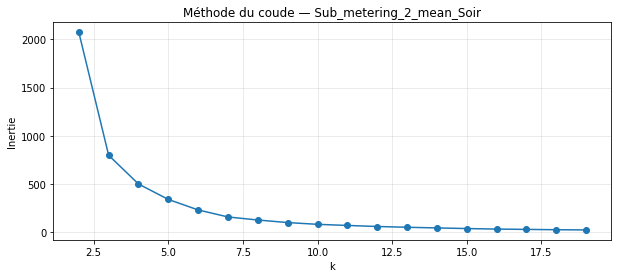

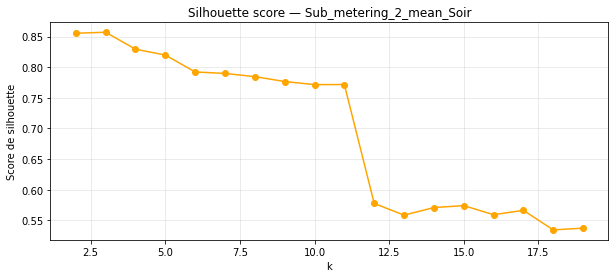

In [159]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#col = "Global_active_power_mean_Nuit"
#col = "Global_active_power_mean_Matin"
#col = "Global_active_power_mean_Apres_Midi"
#col = "Global_active_power_mean_Soir"

#It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave
#col= "Sub_metering_1_mean_Nuit"
#col= "Sub_metering_1_mean_Matin"
#col= "Sub_metering_1_mean_Apres_Midi"
#col= "Sub_metering_1_mean_Soir"

#It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
#col= "Sub_metering_2_mean_Nuit"
#col= "Sub_metering_2_mean_Matin"
#col= "Sub_metering_2_mean_Apres_Midi"
col= "Sub_metering_2_mean_Soir"

#It corresponds to an electric water-heater and an air-conditioner.
#col= "Sub_metering_3_mean_Nuit"
#col= "Sub_metering_3_mean_Matin"
#col= "Sub_metering_3_mean_Apres_Midi"
#col= "Sub_metering_3_mean_Soir"



X = daily_4parts[[col]].dropna().values 

inertias, silhouettes = [], []
K_range = range(2, 20)  

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X)
    
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))

plt.figure(figsize=(10,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.title(f"Méthode du coude — {col}")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K_range, silhouettes, marker="o", color="orange")
plt.xlabel("k")
plt.ylabel("Score de silhouette")
plt.title(f"Silhouette score — {col}")
plt.grid(alpha=0.3)
plt.show()


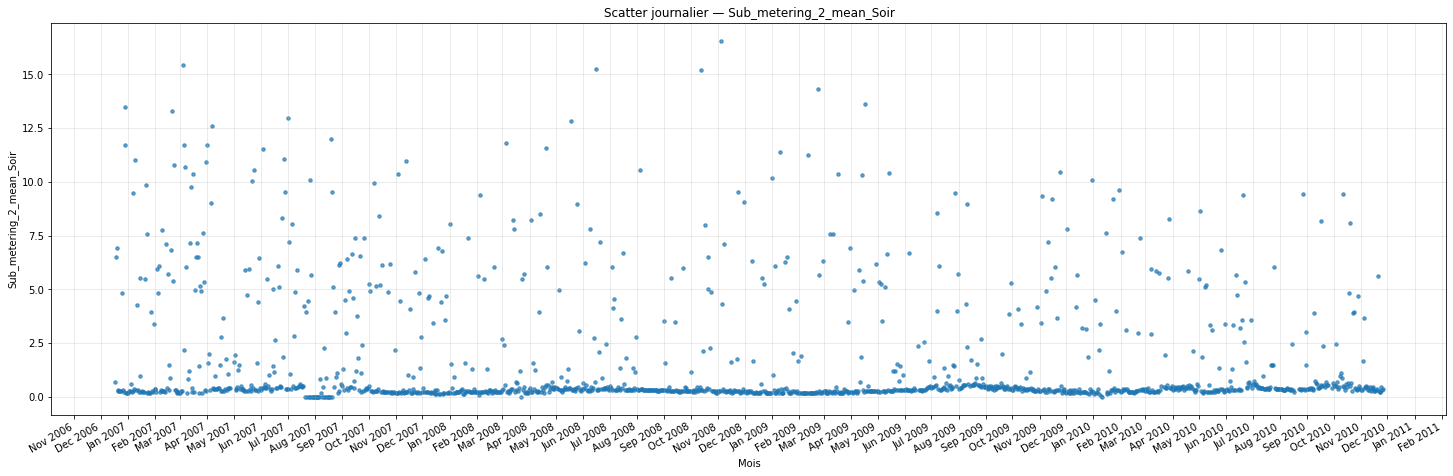

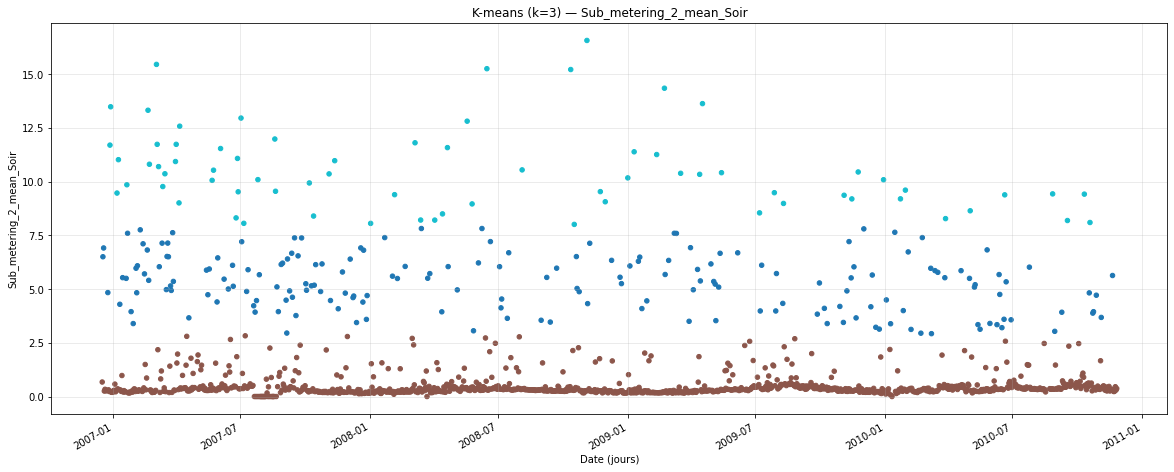

In [160]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans

#col = "Global_active_power_mean_Nuit"
#col = "Global_active_power_mean_Matin"
#col = "Global_active_power_mean_Apres_Midi"
#col = "Global_active_power_mean_Soir"

#col= "Sub_metering_1_mean_Nuit"
#col= "Sub_metering_1_mean_Matin"
#col= "Sub_metering_1_mean_Apres_Midi"
#col= "Sub_metering_1_mean_Soir"

#col= "Sub_metering_2_mean_Nuit"
#col= "Sub_metering_2_mean_Matin"
#col= "Sub_metering_2_mean_Apres_Midi"
col= "Sub_metering_2_mean_Soir"

#col= "Sub_metering_3_mean_Nuit"
#col= "Sub_metering_3_mean_Matin"
#col= "Sub_metering_3_mean_Apres_Midi"
#col= "Sub_metering_3_mean_Soir"





def scatter_by_day_month(df, col):
    s = df[col].dropna()
    # convertir index en datetime si ce n’est pas déjà le cas
    try:
        x = pd.to_datetime(s.index)
    except Exception:
        raise ValueError("⚠️ L’index doit contenir des dates (Day)")

    plt.figure(figsize=(25,8))
    plt.scatter(x, s.values, s=12, alpha=0.7)

    # format de l’axe x = mois
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gcf().autofmt_xdate()

    plt.xlabel("Mois")
    plt.ylabel(col)
    plt.title(f"Scatter journalier — {col}")
    plt.grid(alpha=0.3)
    plt.show()

scatter_by_day_month(daily_4parts,col)





k_optimal = 3
X = daily_4parts[[col]].dropna().values

km = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels = km.fit_predict(X)

df_clusters = daily_4parts[[col]].dropna().copy()
df_clusters["Cluster"] = labels

plt.figure(figsize=(20,8))
plt.scatter(df_clusters.index, df_clusters[col], 
            c=df_clusters["Cluster"], cmap="tab10", s=20)
plt.xlabel("Date (jours)")
plt.ylabel(col)
plt.title(f"K-means (k={k_optimal}) — {col}")
plt.grid(alpha=0.3)
plt.gcf().autofmt_xdate()
plt.show()





         count       mean       std        min        max
Cluster                                                  
0          535   2.994696  0.692264   1.550000   5.008333
1          713   0.064536  0.273405   0.000000   1.525000
2          154   7.046571  1.521702   5.033333  10.938889
3           18  15.012654  2.517823  11.450000  19.925000


<Figure size 432x288 with 0 Axes>

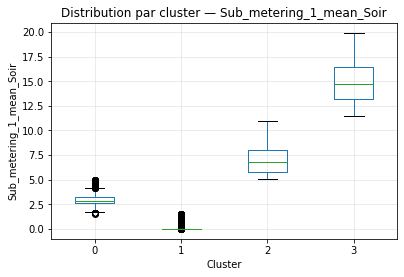

In [144]:
#col = "Global_active_power_mean_Nuit"
#col = "Global_active_power_mean_Matin"
#col = "Global_active_power_mean_Apres_Midi"
#col = "Global_active_power_mean_Soir"

#col= "Sub_metering_1_mean_Nuit"
#col= "Sub_metering_1_mean_Matin"
#col= "Sub_metering_1_mean_Apres_Midi"
col= "Sub_metering_1_mean_Soir"

#col= "Sub_metering_2_mean_Nuit"
#col= "Sub_metering_2_mean_Matin"
#col= "Sub_metering_2_mean_Apres_Midi"
#col= "Sub_metering_2_mean_Soir"

#col= "Sub_metering_3_mean_Nuit"
#col= "Sub_metering_3_mean_Matin"
#col= "Sub_metering_3_mean_Apres_Midi"
#col= "Sub_metering_3_mean_Soir"






cluster_stats = df_clusters.groupby("Cluster")[col].agg(["count","mean","std","min","max"])
print(cluster_stats)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df_clusters.boxplot(column=col, by="Cluster")
plt.title(f"Distribution par cluster — {col}")
plt.suptitle("")  # enlever le titre automatique
plt.xlabel("Cluster")
plt.ylabel(col)
plt.grid(alpha=0.3)
plt.show()


In [176]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def analyse_kmeans(df, col, k_range=range(2,10)):
    X = df[[col]].dropna().values
    
    inertias, silhouettes = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X, labels))
    
    # Coude
    plt.figure(figsize=(8,4))
    plt.plot(k_range, inertias, marker="o")
    plt.title(f"Coude — {col}")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.grid(alpha=0.3)
    plt.show()
    
    # Silhouette
    plt.figure(figsize=(8,4))
    plt.plot(k_range, silhouettes, marker="o", color="orange")
    plt.title(f"Silhouette — {col}")
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.grid(alpha=0.3)
    plt.show()

    # Best k (max silhouette)
    best_k = k_range[silhouettes.index(max(silhouettes))]
    print(f"👉 Best k for {col}: {best_k}, silhouette={max(silhouettes):.3f}")
    
    # Final model
    km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    df_out = df[[col]].dropna().copy()
    df_out["Cluster"] = labels
    
    # Scatter with months on x-axis
    plt.figure(figsize=(20,5))
    plt.scatter(df_out.index, df_out[col], c=df_out["Cluster"], cmap="tab10", s=20)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # ay bazında tick
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # ör: Jan 2007
    
    plt.title(f"K-means clustering — {col} (k={best_k})")
    plt.xlabel("Mois")
    plt.ylabel(col)
    plt.gcf().autofmt_xdate()
    plt.grid(alpha=0.3)
    plt.show()
    
    return df_out, best_k


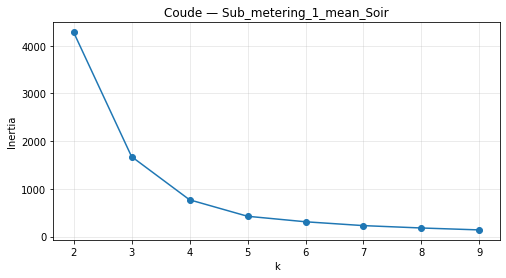

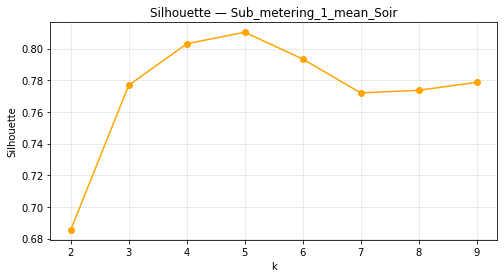

👉 Best k for Sub_metering_1_mean_Soir: 5, silhouette=0.810


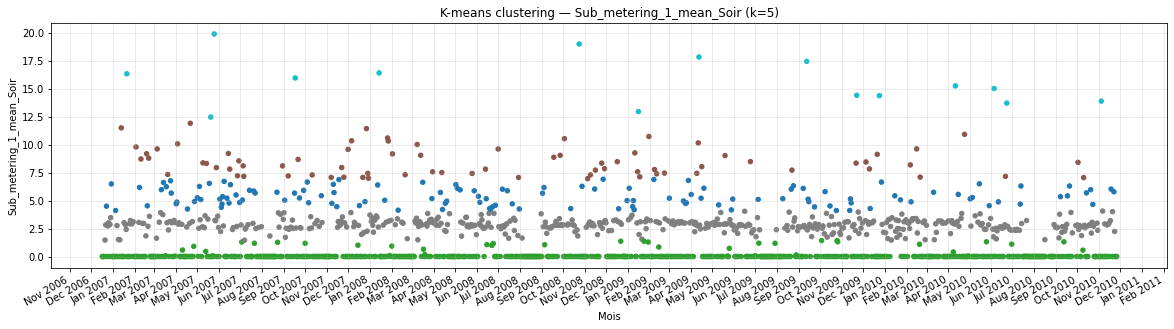

In [177]:
df_sub1, k1 = analyse_kmeans(daily_4parts, "Sub_metering_1_mean_Soir")



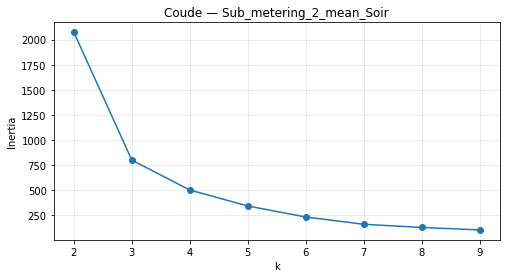

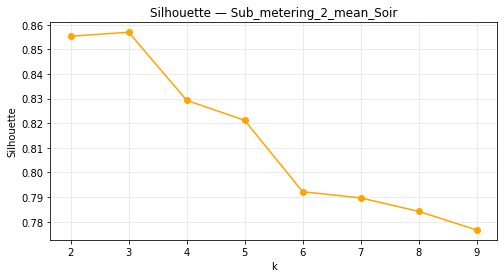

👉 Best k for Sub_metering_2_mean_Soir: 3, silhouette=0.857


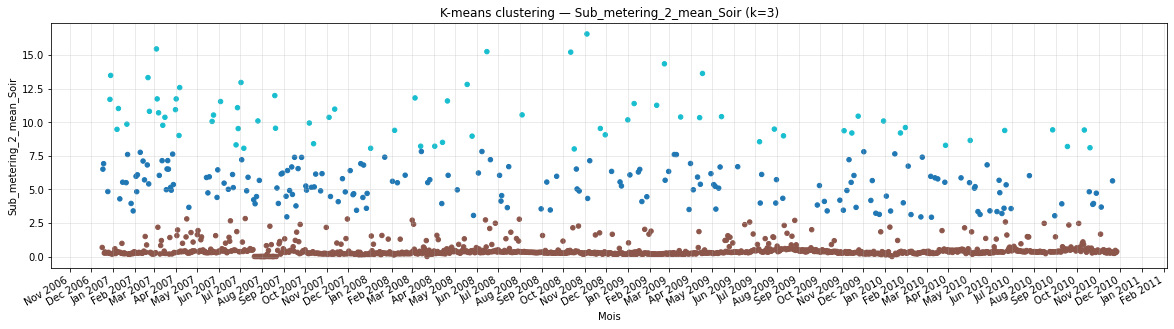

In [178]:
df_sub2, k2 = analyse_kmeans(daily_4parts, "Sub_metering_2_mean_Soir")


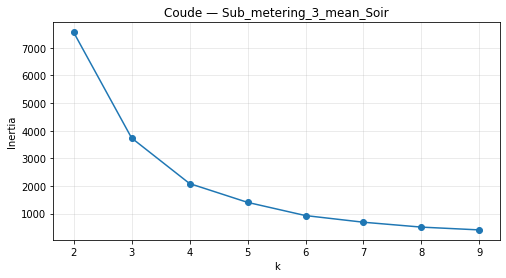

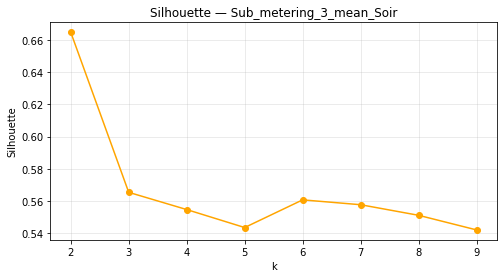

👉 Best k for Sub_metering_3_mean_Soir: 2, silhouette=0.665


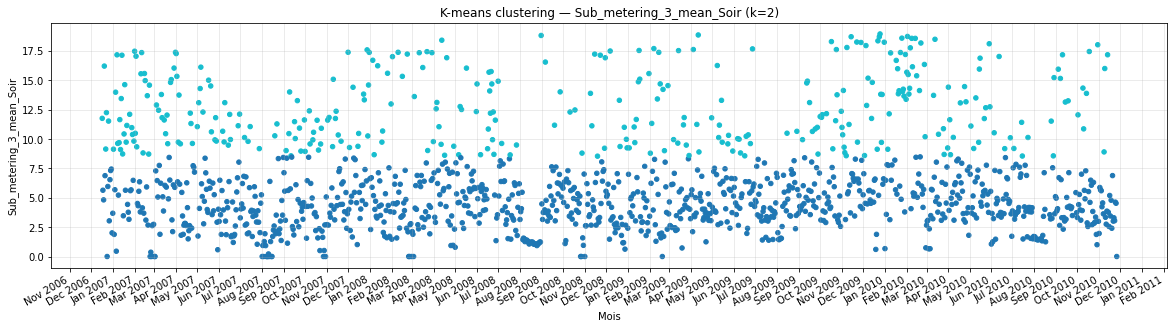

In [179]:
df_sub3, k3 = analyse_kmeans(daily_4parts, "Sub_metering_3_mean_Soir")

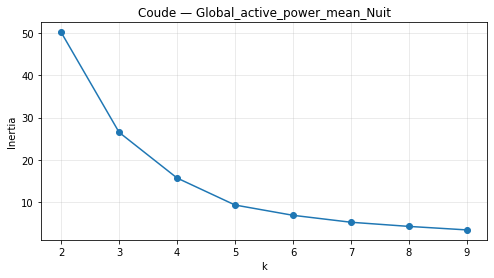

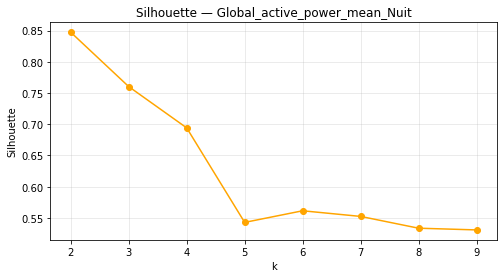

👉 Best k for Global_active_power_mean_Nuit: 2, silhouette=0.847


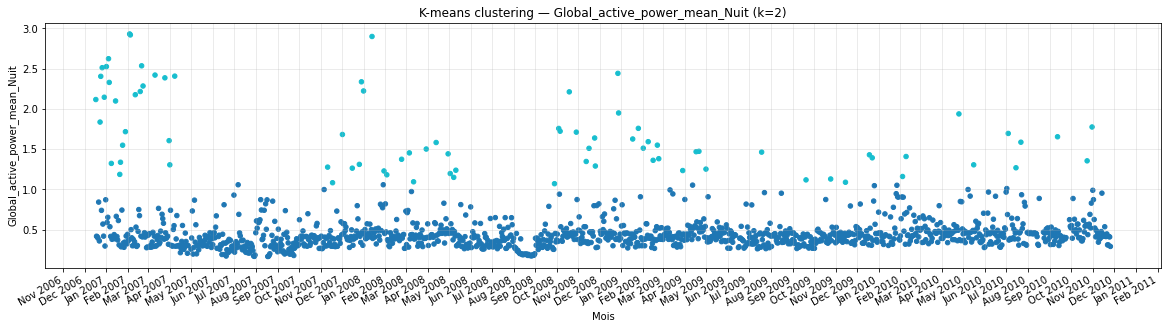

In [180]:
df_sub4, k4 = analyse_kmeans(daily_4parts, "Global_active_power_mean_Nuit")




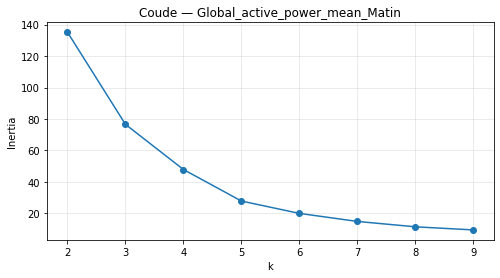

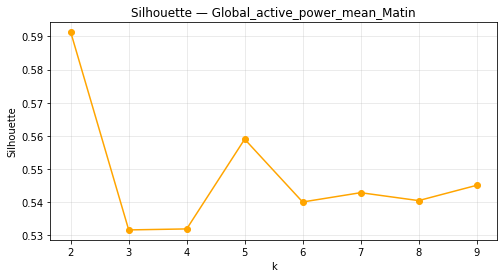

👉 Best k for Global_active_power_mean_Matin: 2, silhouette=0.591


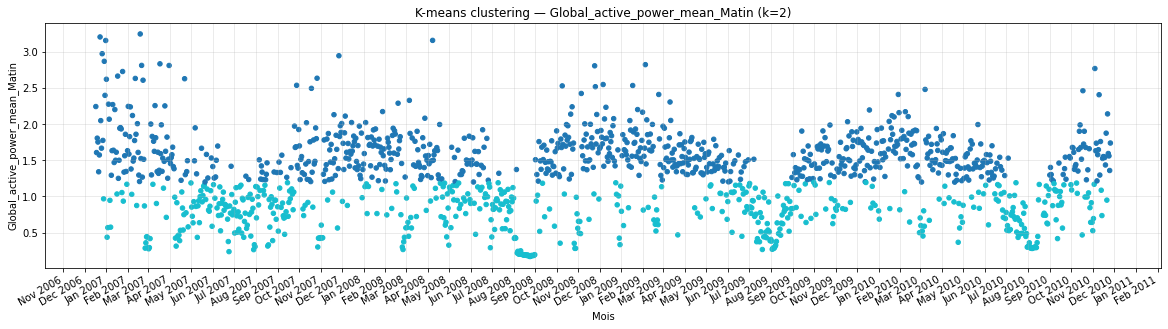

In [181]:
df_sub5, k5 = analyse_kmeans(daily_4parts, "Global_active_power_mean_Matin")

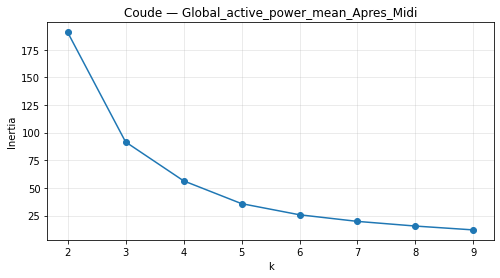

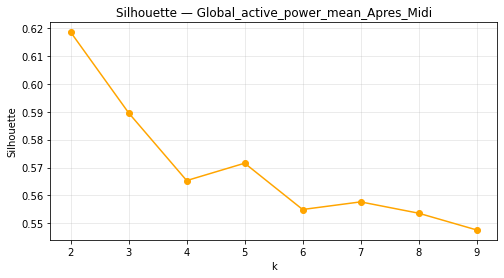

👉 Best k for Global_active_power_mean_Apres_Midi: 2, silhouette=0.618


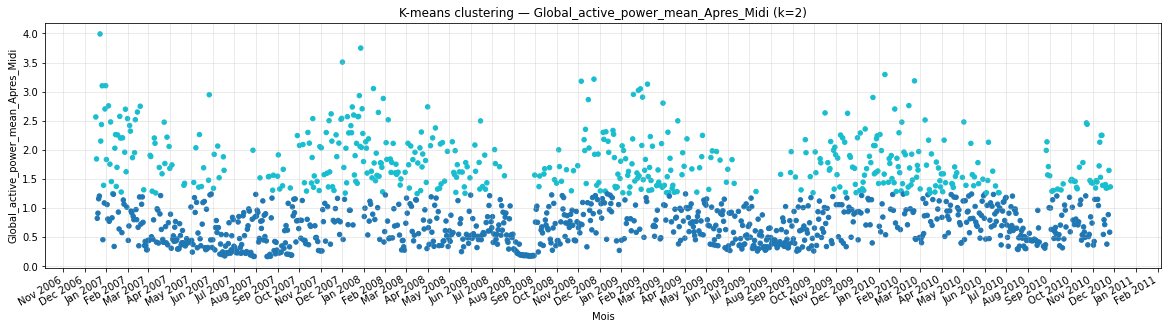

In [182]:
df_sub6, k6 = analyse_kmeans(daily_4parts, "Global_active_power_mean_Apres_Midi")

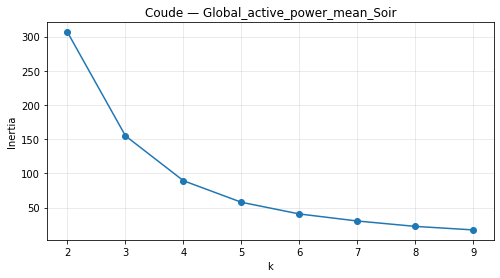

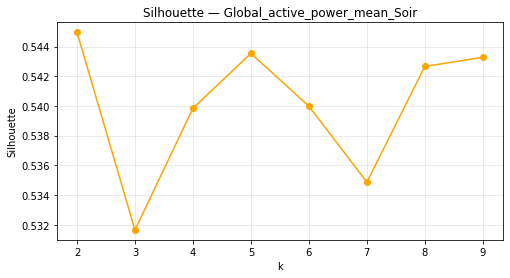

👉 Best k for Global_active_power_mean_Soir: 2, silhouette=0.545


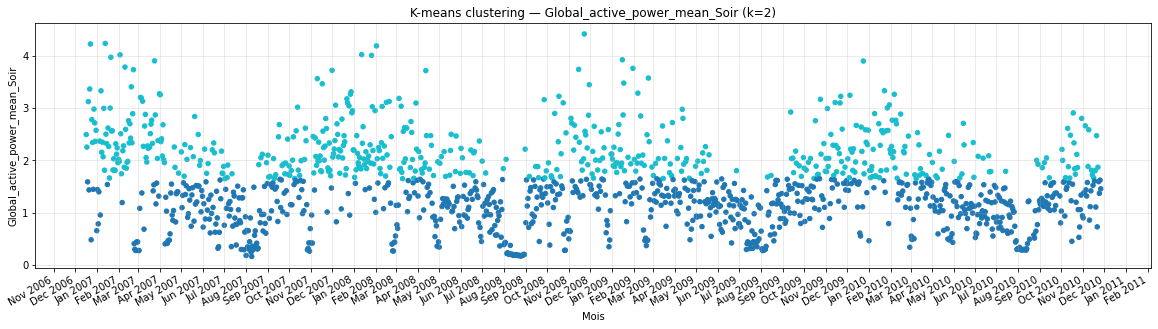

In [183]:
df_sub7, k7 = analyse_kmeans(daily_4parts, "Global_active_power_mean_Soir")

In [187]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def analyse_gmm(df, col, k_range=range(1,6)):
    X = df[[col]].dropna().values
    
    # Model selection with BIC
    bics, aics = [], []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X)
        bics.append(gmm.bic(X))
        aics.append(gmm.aic(X))
    
    # Plot BIC & AIC
    plt.figure(figsize=(8,4))
    plt.plot(k_range, bics, marker="o", label="BIC")
    plt.plot(k_range, aics, marker="s", label="AIC")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Score")
    plt.title(f"GMM model selection — {col}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Best k (min BIC)
    best_k = k_range[np.argmin(bics)]
    print(f"👉 Best k for {col} (by BIC): {best_k}")
    
    # Fit final GMM
    gmm = GaussianMixture(n_components=best_k, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    probs = gmm.predict_proba(X)
    
    # DataFrame output
    df_out = df[[col]].dropna().copy()
    df_out["Cluster"] = labels
    
    for i in range(best_k):
        df_out[f"Prob_cluster{i}"] = probs[:,i]
    
    # Scatter over time (x-axis = months)
    plt.figure(figsize=(20,5))
    plt.scatter(df_out.index, df_out[col], c=labels, cmap="tab10", s=20)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())              # ay tickleri
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))    # format örn: Jan 2007
    
    plt.title(f"GMM clustering — {col} (k={best_k})")
    plt.xlabel("Mois")
    plt.ylabel(col)
    plt.gcf().autofmt_xdate()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Histogram + GMM fit
    x = np.linspace(X.min(), X.max(), 500).reshape(-1,1)
    logprob = gmm.score_samples(x)
    responsibilities = gmm.predict_proba(x)
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    plt.figure(figsize=(8,4))
    plt.hist(X, bins=50, density=True, alpha=0.4, color="gray")
    plt.plot(x, pdf, "-k", label="GMM total")
    for i in range(best_k):
        plt.plot(x, pdf_individual[:,i], "--", label=f"Cluster {i}")
    plt.legend()
    plt.title(f"GMM fit — {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()
    
    return df_out, best_k


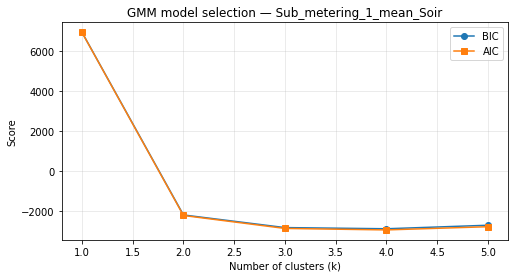

👉 Best k for Sub_metering_1_mean_Soir (by BIC): 4


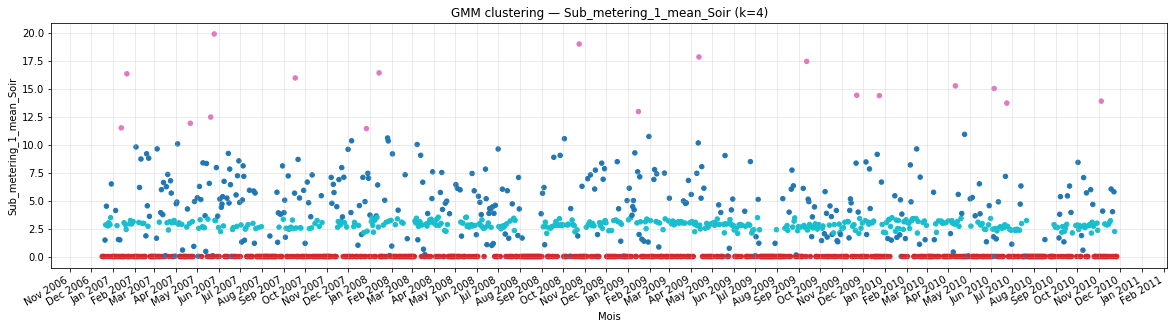

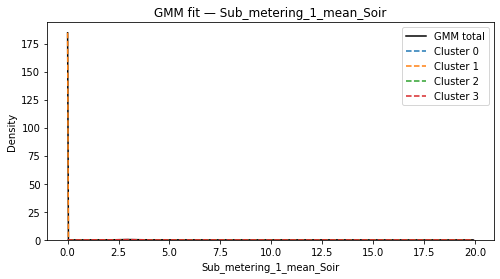

In [189]:
df_sub1, k1 = analyse_gmm(daily_4parts, "Sub_metering_1_mean_Soir")


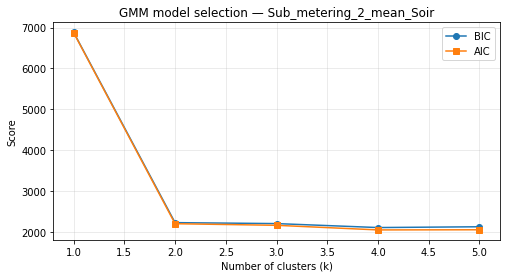

👉 Best k for Sub_metering_2_mean_Soir (by BIC): 4


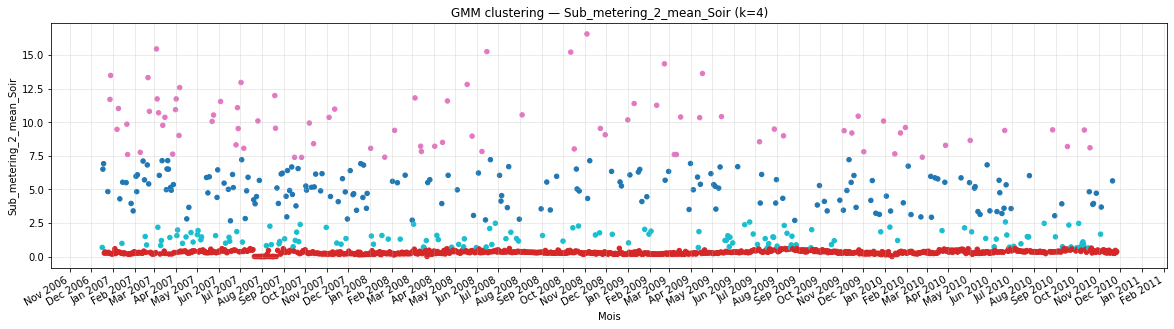

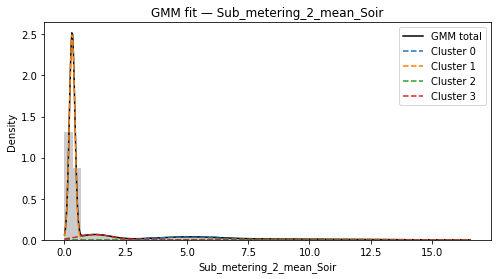

In [192]:
df_sub2, k2 = analyse_gmm(daily_4parts, "Sub_metering_2_mean_Soir")


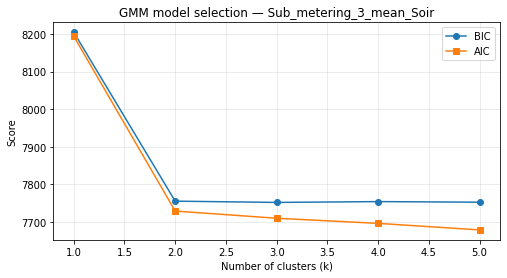

👉 Best k for Sub_metering_3_mean_Soir (by BIC): 3


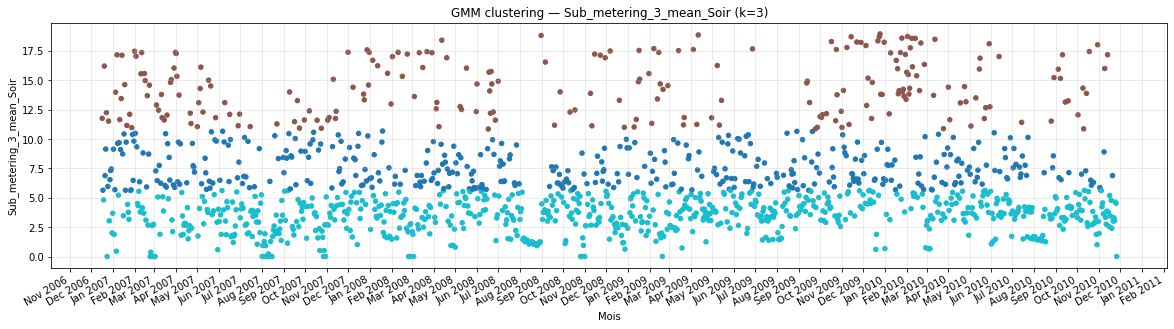

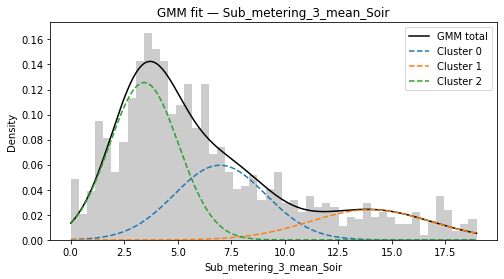

In [191]:
df_sub3, k3 = analyse_gmm(daily_4parts, "Sub_metering_3_mean_Soir")


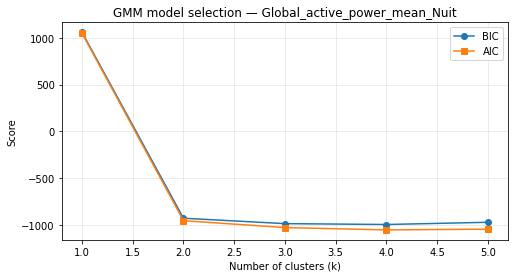

👉 Best k for Global_active_power_mean_Nuit (by BIC): 4


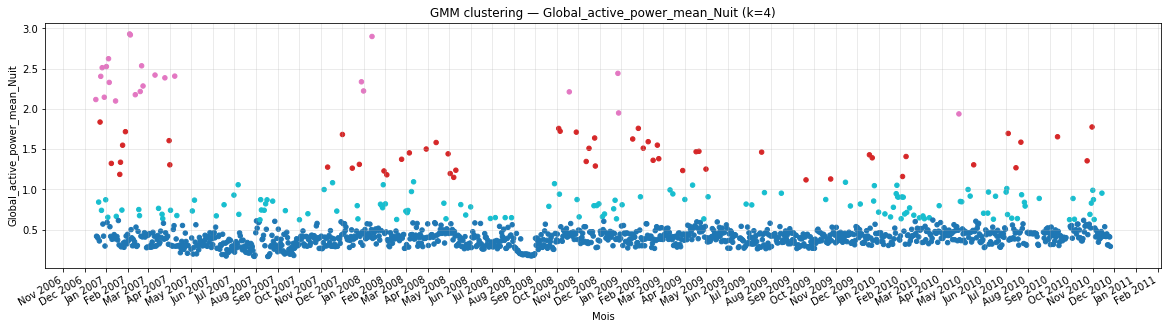

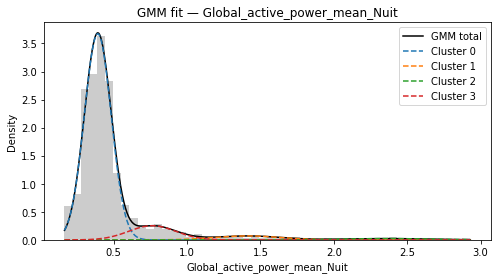

In [193]:
df_sub4, k4 = analyse_gmm(daily_4parts, "Global_active_power_mean_Nuit")


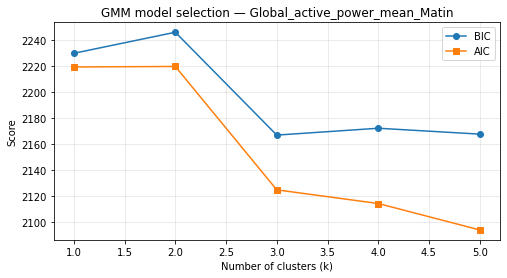

👉 Best k for Global_active_power_mean_Matin (by BIC): 3


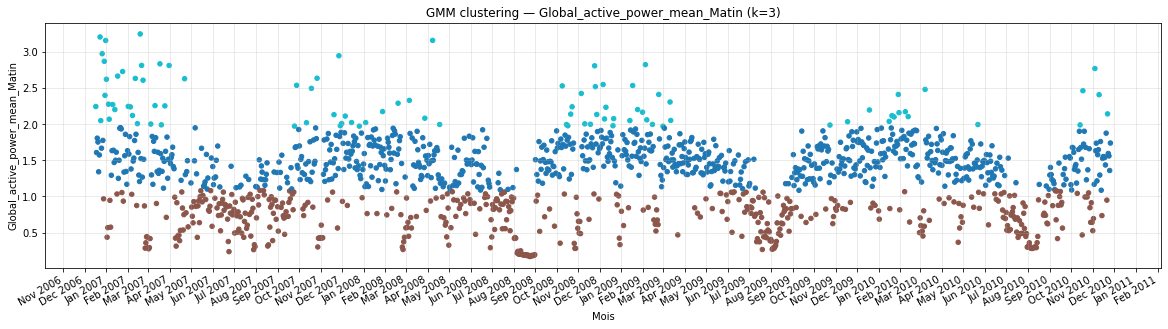

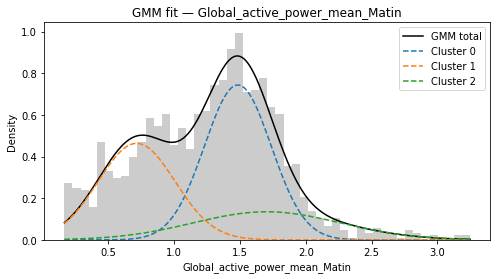

In [194]:
df_sub5, k5 = analyse_gmm(daily_4parts, "Global_active_power_mean_Matin")


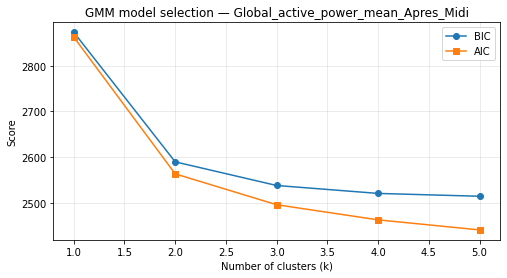

👉 Best k for Global_active_power_mean_Apres_Midi (by BIC): 5


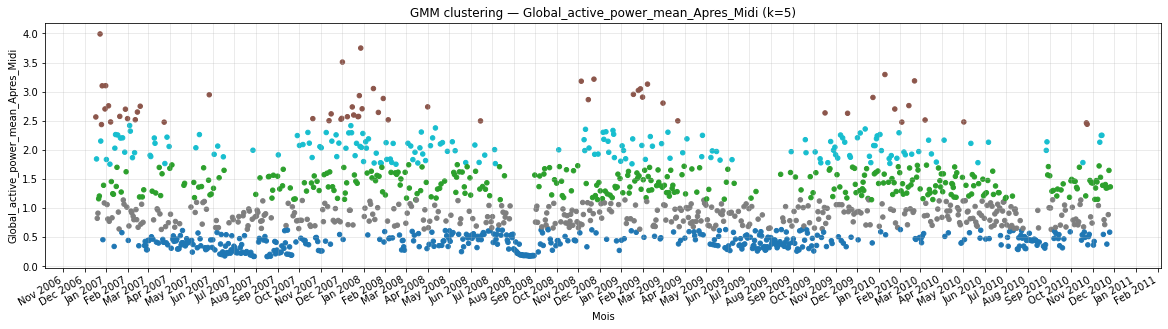

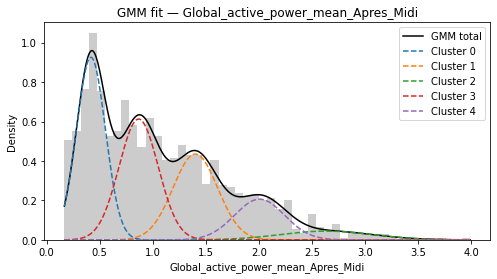

In [206]:
df_sub6, k6 = analyse_gmm(daily_4parts, "Global_active_power_mean_Apres_Midi")


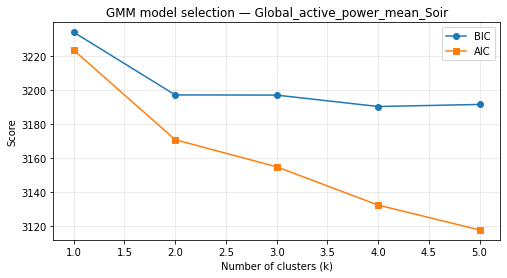

👉 Best k for Global_active_power_mean_Soir (by BIC): 4


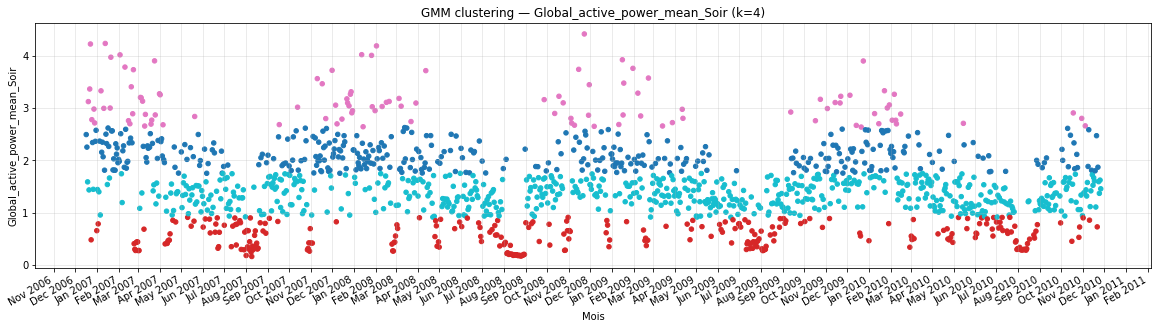

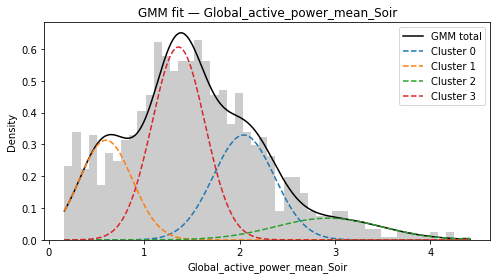

In [203]:
df_sub7, k7 = analyse_gmm(daily_4parts, "Global_active_power_mean_Soir")

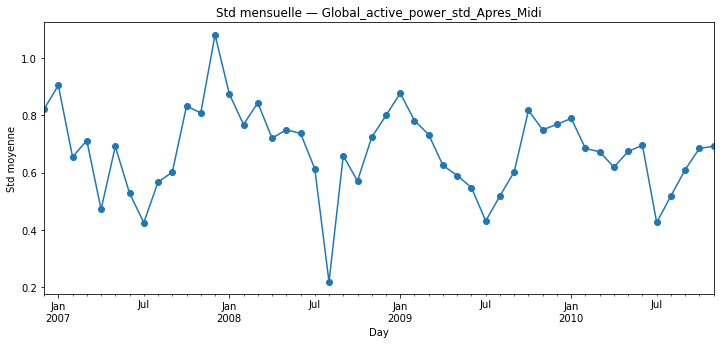

In [213]:
# Eğer index aslında tarihleri içeriyorsa:
daily_4parts.index = pd.to_datetime(daily_4parts.index)

col = "Global_active_power_std_Apres_Midi"
std_monthly = daily_4parts[col].groupby(daily_4parts.index.to_period("M")).mean()
std_monthly.plot(figsize=(12,5), marker="o")
plt.title(f"Std mensuelle — {col}")
plt.ylabel("Std moyenne")
plt.show()



👉 Best k (by BIC): 3


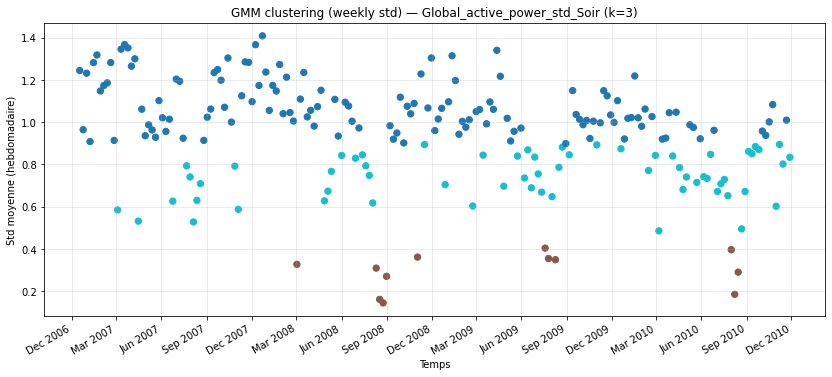

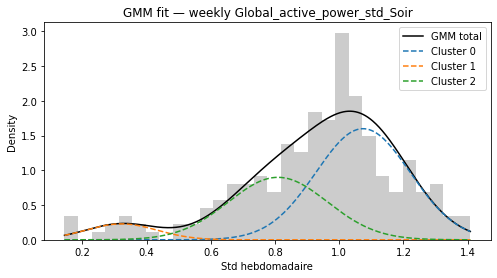

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.dates as mdates

col = "Global_active_power_std_Soir"

# 1. Index'i datetime yapalım (eğer değilse)
daily_4parts.index = pd.to_datetime(daily_4parts.index)

# 2. Haftalık ortalama std hesapla
std_weekly = daily_4parts[col].resample("W").mean()

# 3. GMM için X matrisi
X = std_weekly.dropna().values.reshape(-1,1)

# 4. GMM fit (ör: 2–4 cluster dene)
n_components = range(1,6)
bics = []
for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))

print(f"👉 Best k (by BIC): {best_k}")
best_k = 3
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

# 5. DataFrame'e ekle
df_weekly = pd.DataFrame({
    "Std_weekly": std_weekly.dropna(),
    "Cluster": labels
})

# 6. Zaman ekseni scatter (haftalık)
plt.figure(figsize=(14,6))
plt.scatter(df_weekly.index, df_weekly["Std_weekly"], 
            c=df_weekly["Cluster"], cmap="tab10", s=40)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3 ayda bir tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title(f"GMM clustering (weekly std) — {col} (k={best_k})")
plt.xlabel("Temps")
plt.ylabel("Std moyenne (hebdomadaire)")
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.3)
plt.show()

# 7. Histogram + GMM fit
x = np.linspace(X.min(), X.max(), 500).reshape(-1,1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(8,4))
plt.hist(X, bins=30, density=True, alpha=0.4, color="gray")
plt.plot(x, pdf, "-k", label="GMM total")
for i in range(best_k):
    plt.plot(x, pdf_individual[:,i], "--", label=f"Cluster {i}")
plt.legend()
plt.title(f"GMM fit — weekly {col}")
plt.xlabel("Std hebdomadaire")
plt.ylabel("Density")
plt.show()
